In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=831368099284b86f29f905ba6abad04f4d1fc8d4f0ef98fd31099f1b5a990577
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


In [ ]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import zscore, median_abs_deviation, entropy
from factor_analyzer import FactorAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, balanced_accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve

# Ignore warnings
warnings.simplefilter("ignore")



---

Data Simulation

---



In [ ]:
# Set random seed
np.random.seed(42)

# Define number of samples and features
n_samples = 400
n_features = 20

# Generate a few base features
base_features = np.random.randint(1, 6, size=(n_samples, 5))

# Create correlated features by adding slight variations to base features
correlated_features = np.hstack([
    base_features,  # Original base features
    base_features + np.random.randint(-1, 2, size=(n_samples, 5)),  # Slight variations
    base_features + np.random.randint(-1, 2, size=(n_samples, 5)),  # Another variation set
    np.random.randint(1, 6, size=(n_samples, 5))  # Independent features
])

# Clip values to stay within range [1, 5]
correlated_features = np.clip(correlated_features, 1, 5)

# Create DataFrame
columns = [f'Q{i+1}' for i in range(n_features)]
df = pd.DataFrame(correlated_features[:, :n_features], columns=columns)

# Generate target variable (Purchase: 0 or 1) based on correlated features
df['Purchase'] = (df[['Q3', 'Q7', 'Q12', 'Q16', 'Q19']].mean(axis=1) > 3).astype(int)

# Display first few rows
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Purchase
0,4,5,3,5,5,5,5,3,4,5,...,4,2,5,5,1,2,1,1,2,0
1,2,3,3,3,5,1,2,2,3,4,...,3,3,4,5,2,1,5,2,3,0
2,4,3,5,2,4,4,4,5,1,4,...,3,4,1,5,4,1,1,4,5,1
3,2,4,5,1,4,3,4,5,1,5,...,4,4,1,5,4,2,4,1,4,1
4,2,5,4,1,1,1,4,5,2,1,...,5,3,1,1,3,2,4,1,2,1




---

EDA

---



           Q1        Q2        Q3        Q4        Q5        Q6        Q7  \
Q1   1.000000  0.074376  0.044291  0.085630  0.125857  0.875507  0.081074   
Q2   0.074376  1.000000  0.042900 -0.004673  0.122876  0.049677  0.875028   
Q3   0.044291  0.042900  1.000000  0.027223  0.072514  0.036848  0.072410   
Q4   0.085630 -0.004673  0.027223  1.000000  0.133007  0.100921  0.028940   
Q5   0.125857  0.122876  0.072514  0.133007  1.000000  0.140265  0.125497   
Q6   0.875507  0.049677  0.036848  0.100921  0.140265  1.000000  0.058978   
Q7   0.081074  0.875028  0.072410  0.028940  0.125497  0.058978  1.000000   
Q8   0.062089  0.050904  0.877596  0.017221  0.096397  0.055926  0.087881   
Q9   0.114374  0.011367  0.050270  0.886234  0.111757  0.140234  0.042709   
Q10  0.133749  0.128909  0.103771  0.141823  0.874038  0.163293  0.130512   
Q11  0.878674  0.040550  0.058375  0.074503  0.135817  0.774012  0.038417   
Q12  0.085488  0.891405  0.025993 -0.004529  0.091546  0.053188  0.802164   

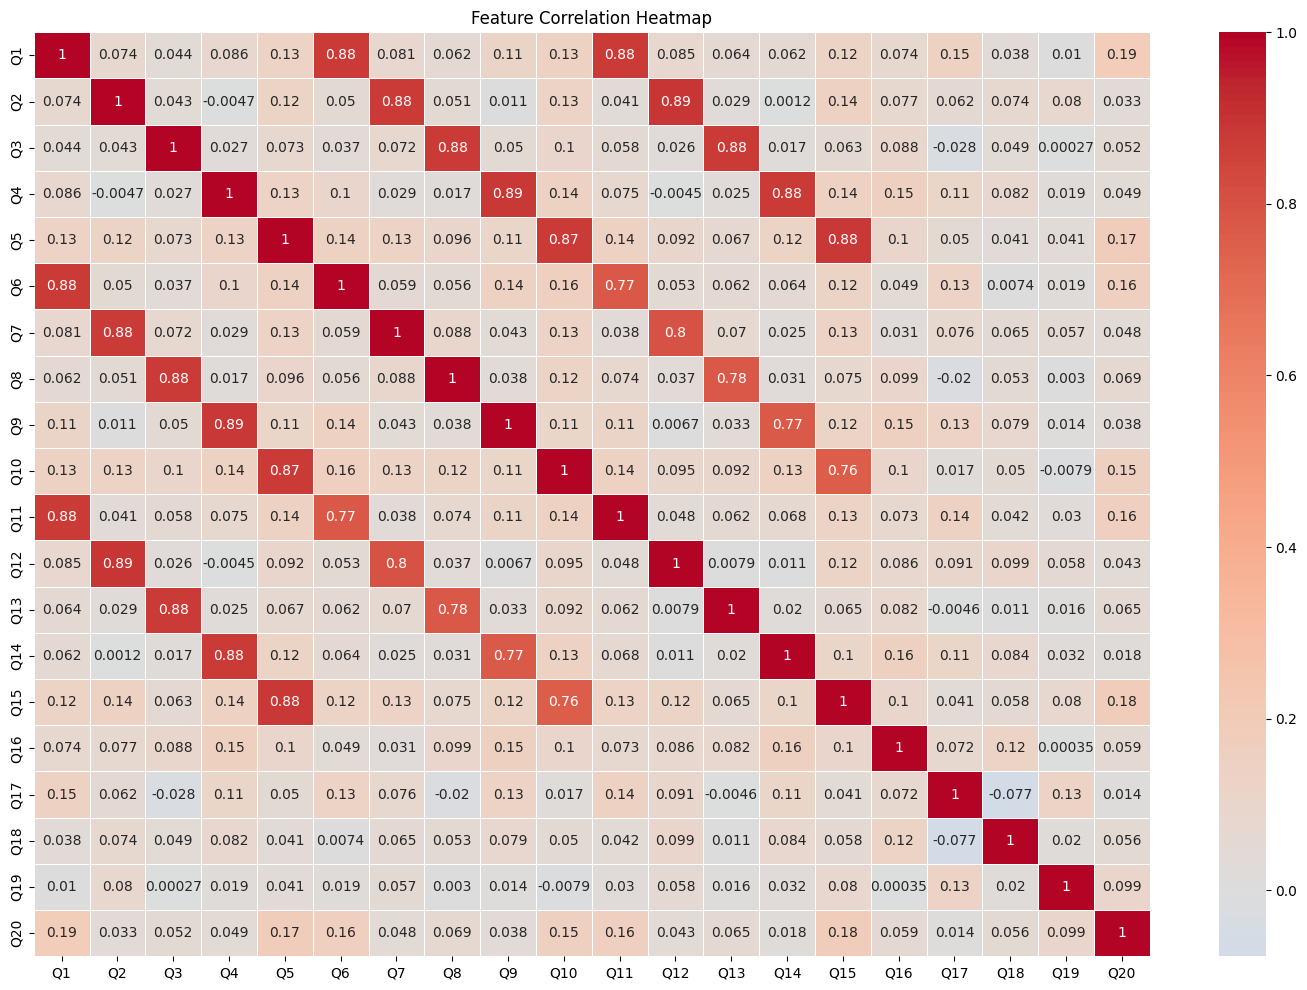

In [ ]:
# --- 1. Correlation Heatmap ---
plt.figure(figsize=(18, 12))
corr_matrix = df.drop(columns=['Purchase']).corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

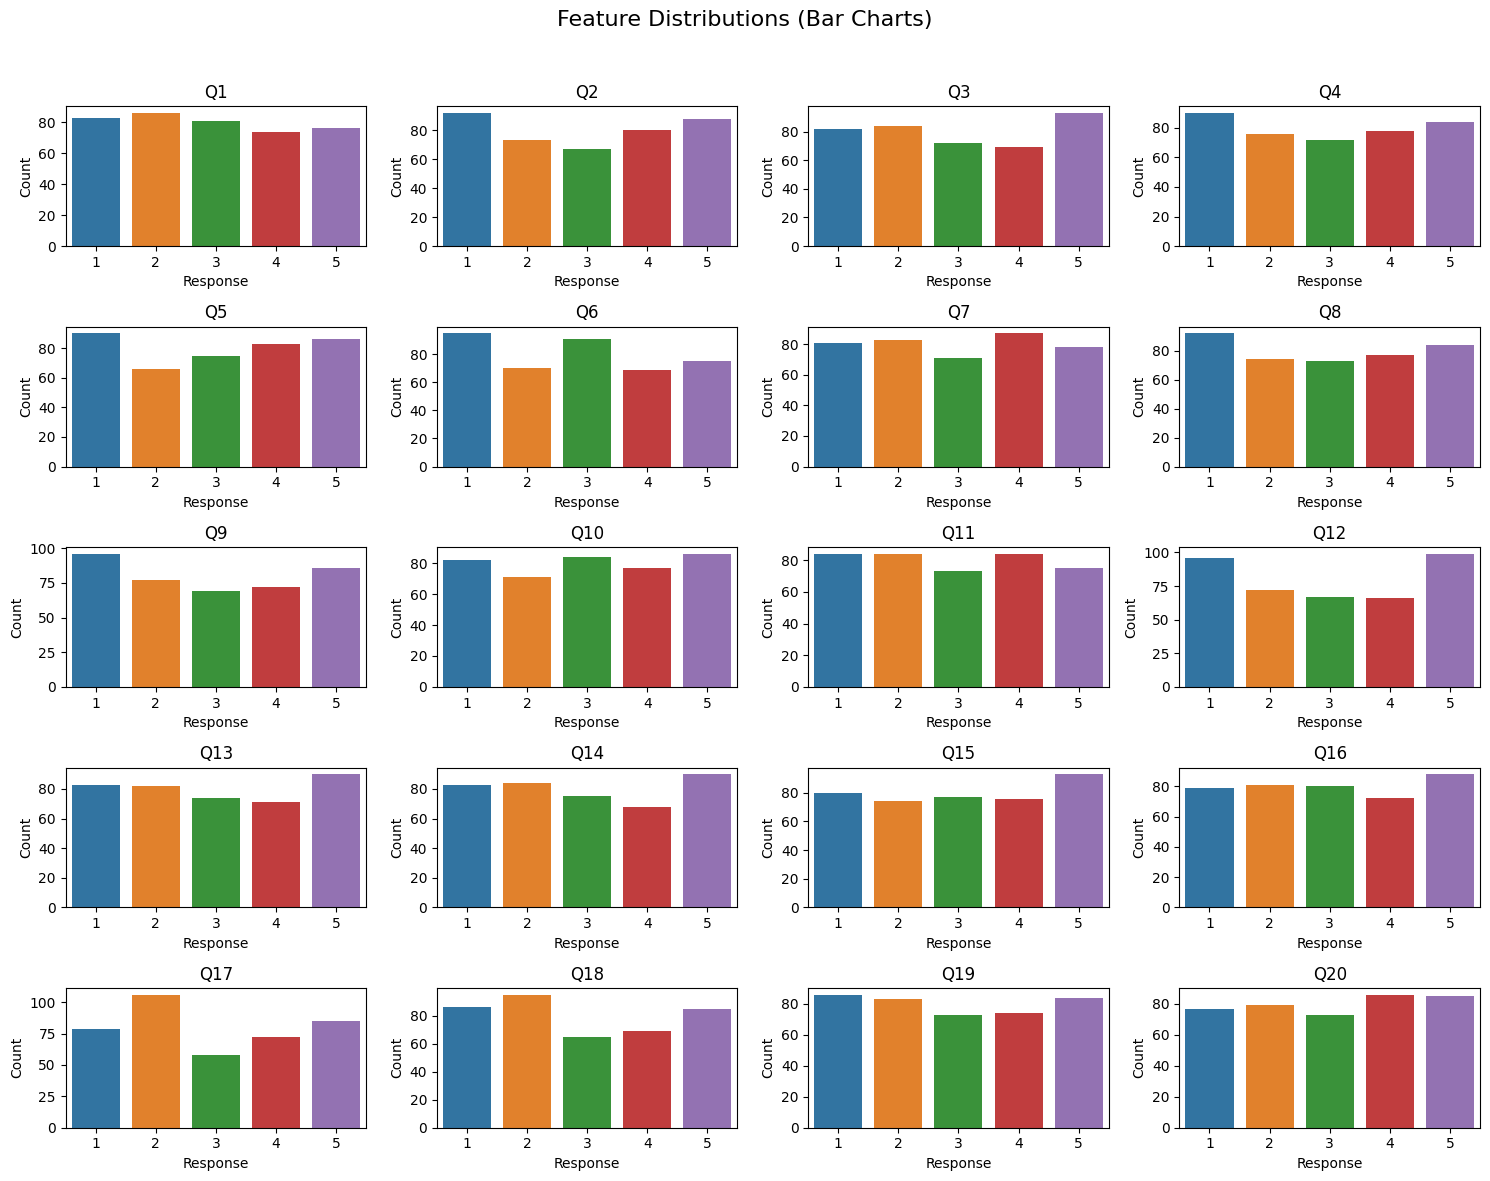

In [ ]:
# --- 2. Bar Charts for Feature Distributions ---
fig, axes = plt.subplots(5, 4, figsize=(15, 12))
fig.suptitle("Feature Distributions (Bar Charts)", fontsize=16)

for i, col in enumerate(df.drop(columns=['Purchase']).columns):
    ax = axes[i // 4, i % 4]
    sns.countplot(x=df[col], ax=ax, palette='tab10')
    ax.set_title(col)
    ax.set_xlabel('Response')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
print("dataset shape:", df.shape)

dataset shape: (400, 21)




---

Factor Analysis

---



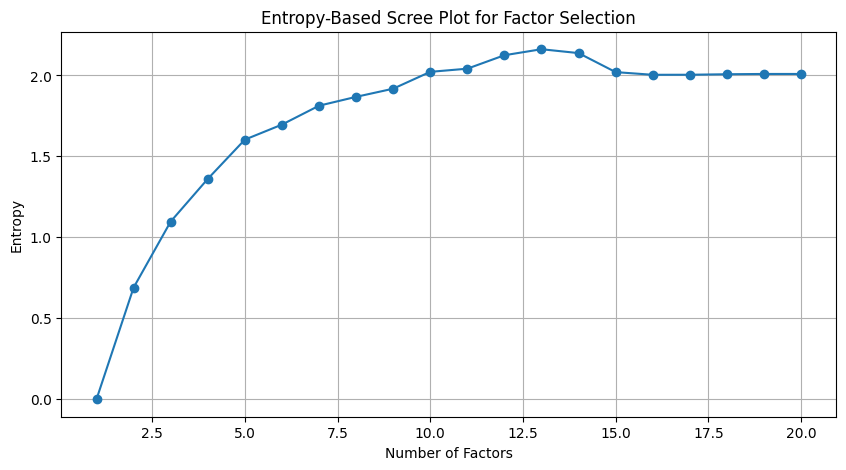

In [ ]:
# --- Factor Selection using Entropy-Based Scree Plot ---
entropy_values = []
for num_factors in range(1, df.shape[1]):
    fa = FactorAnalyzer(n_factors=num_factors, rotation=None)
    fa.fit(df.drop(columns=['Purchase']))
    loadings = fa.loadings_
    factor_variance = np.var(loadings, axis=0)
    entropy_values.append(entropy(factor_variance))

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(entropy_values) + 1), entropy_values, marker='o', linestyle='-')
plt.xlabel('Number of Factors')
plt.ylabel('Entropy')
plt.title('Entropy-Based Scree Plot for Factor Selection')
plt.grid()
plt.show()

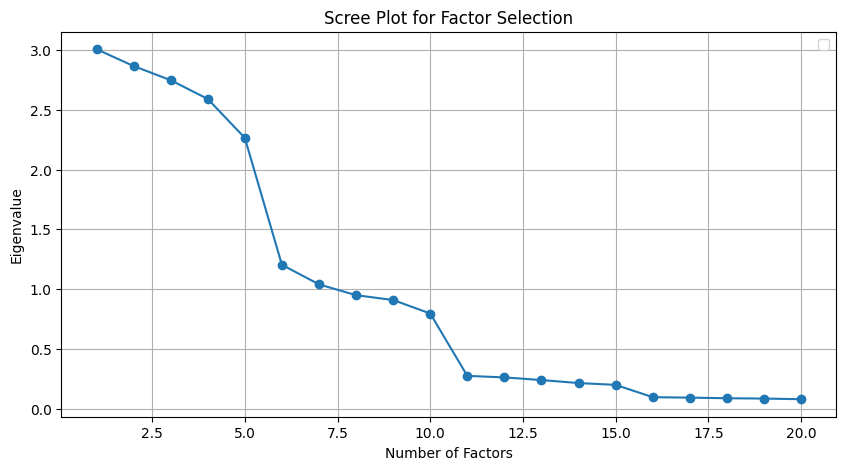

In [ ]:
# --- Factor Selection using Scree Plot ---
fa = FactorAnalyzer(n_factors=df.shape[1] - 1, rotation=None)
fa.fit(df.drop(columns=['Purchase']))

eigenvalues, _ = fa.get_eigenvalues()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
#plt.axhline(y=1, color='r', linestyle='--', label="Kaiser Criterion (Eigenvalue = 1)")
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot for Factor Selection')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# --- Factor Analysis ---
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(df.drop(columns=['Purchase']))

# Get factor loadings
factor_scores = fa.transform(df.drop(columns=['Purchase']))
df_factors = pd.DataFrame(factor_scores, columns=[f'Factor {i+1}' for i in range(5)])
df_factors['Purchase'] = df['Purchase']

In [ ]:
# Display the new DataFrame
display(df_factors.head())

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Purchase
0,0.032545,1.371708,0.720783,1.483558,1.204265,0
1,-0.008602,-0.120349,-0.717104,-0.005256,1.480843,0
2,1.419334,0.016092,0.820750,-0.549537,0.640236,1
3,1.477731,0.636377,-0.627956,-1.254065,0.737621,1
4,0.659849,1.360944,-0.645301,-1.265793,-1.337131,1


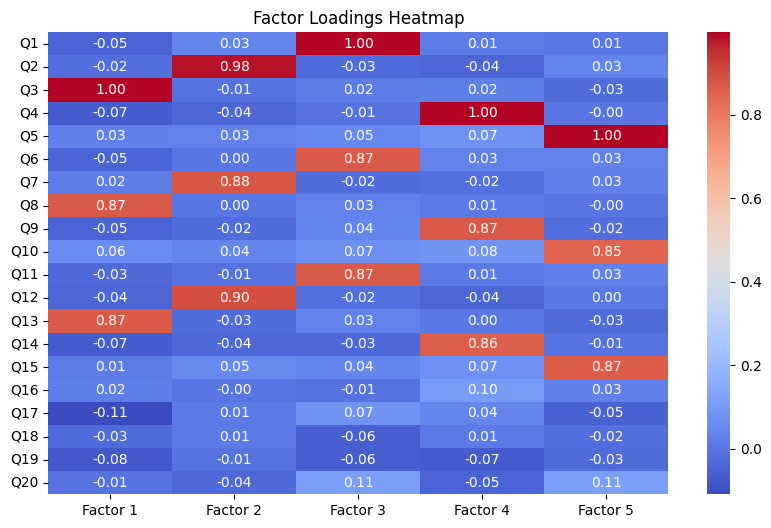

In [ ]:
# Plot heatmap of factor loadings
factor_loadings = pd.DataFrame(fa.loadings_, index=df.drop(columns=['Purchase']).columns, columns=[f'Factor {i+1}' for i in range(5)])
plt.figure(figsize=(10, 6))
sns.heatmap(factor_loadings, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Factor Loadings Heatmap")
plt.show()




---

Building Machine learning model

---



In [ ]:
# --- Machine Learning Models ---
def train_and_evaluate(X, y, dataset_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Random Forest": RandomForestClassifier(random_state=42),
    }

    print(f"\nPerformance on {dataset_name} dataset:")
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]

        print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        print(f"Confusion Matrix for {name}:\n", confusion_matrix(y_test, y_pred))

        # Balanced Accuracy
        print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

        # ROC-AUC Curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_probs):.4f}")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.figure()
    plt.plot(recall, precision, label=f"{name} Precision-Recall Curve")
    plt.legend()
    plt.title("Precision-Recall Curve")
    plt.show()

    # Probability Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o", label=f"{name} Calibration Curve")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.legend()
    plt.title("Probability Calibration Curve")
    plt.show()

    # Brier Score
    print(f"Brier Score for {name}: {brier_score_loss(y_test, y_probs):.4f}")


Performance on Original 20 Features dataset:
Random Forest Accuracy: 0.8701
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        48
           1       0.77      0.93      0.84        29

    accuracy                           0.87        77
   macro avg       0.86      0.88      0.87        77
weighted avg       0.88      0.87      0.87        77

Confusion Matrix for Random Forest:
 [[40  8]
 [ 2 27]]
Balanced Accuracy: 0.8822


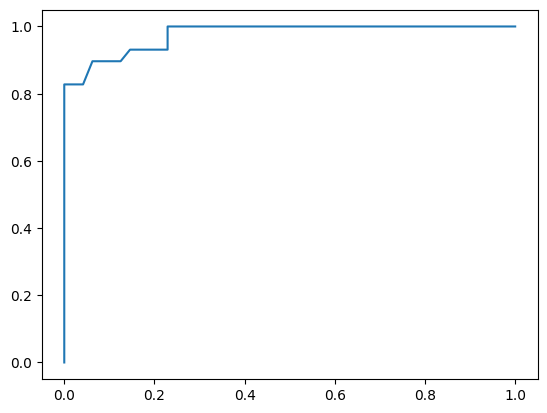

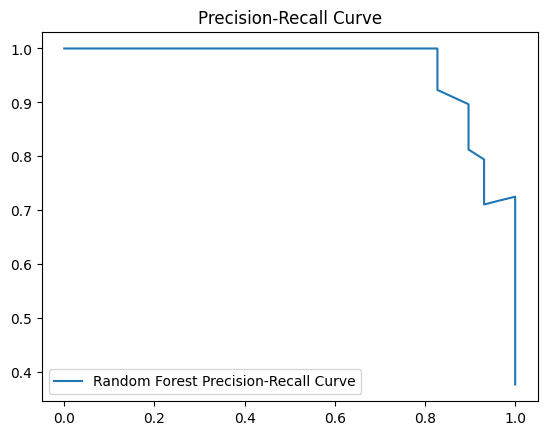

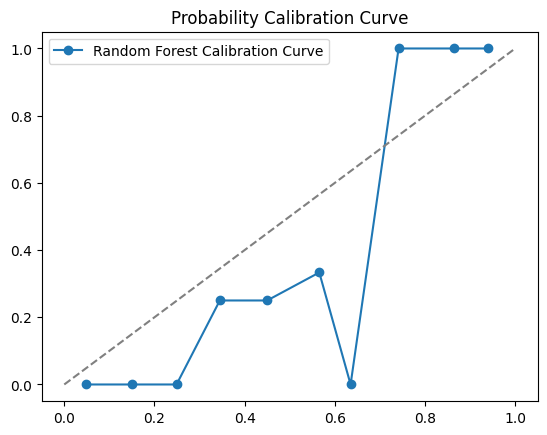

Brier Score for Random Forest: 0.0845


In [ ]:
# Train and evaluate on original 20 features
X_original = df.drop(columns=['Purchase'])
y = df['Purchase']
train_and_evaluate(X_original, y, "Original 20 Features")




Performance on Factor-Reduced 5 Features dataset:
Random Forest Accuracy: 0.8052
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        48
           1       0.69      0.86      0.77        29

    accuracy                           0.81        77
   macro avg       0.80      0.82      0.80        77
weighted avg       0.82      0.81      0.81        77

Confusion Matrix for Random Forest:
 [[37 11]
 [ 4 25]]
Balanced Accuracy: 0.8165


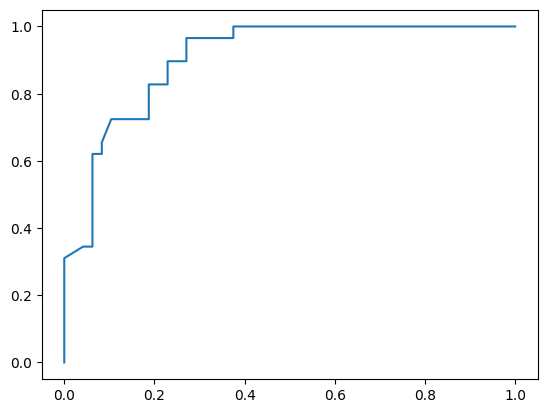

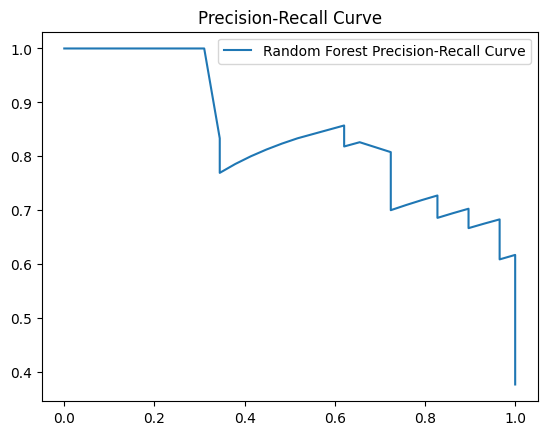

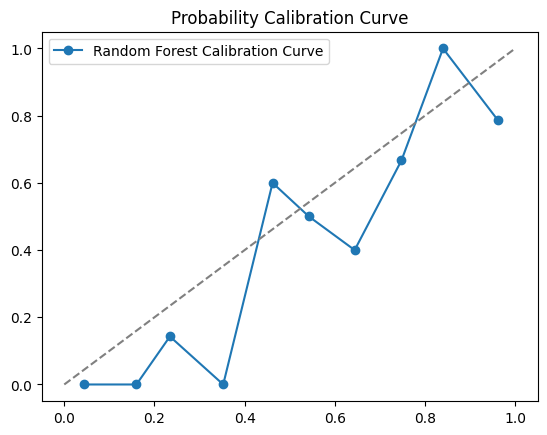

Brier Score for Random Forest: 0.1340


In [ ]:
# Train and evaluate on reduced 5 factors
X_factors = df_factors.drop(columns=['Purchase'])
train_and_evaluate(X_factors, y, "Factor-Reduced 5 Features")